In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Downloading and loading that data with preprocessing for YOLOv8

In [2]:
import os
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import Kitti
from PIL import Image
import numpy as np

In [3]:
kitti_dir = "/content/drive/My Drive/MOSEF/DL"

**Preprocessing for YOLOv8**

YOLOv8 expects:
 - Square images (typically 640x640)
 - Normalized pixel values [0,1]
 - No need for mean/std normalization as YOLOv8 handles this internally

In [4]:
yolo_transform = transforms.Compose([
    transforms.Resize((640, 640)),  # YOLOv8 default size
    transforms.ToTensor(),  # Converts to [0,1] range
])

In [5]:
# Download the dataset with YOLOv8 preprocessing
try:
    print("Downloading training data with YOLOv8 preprocessing...")
    kitti_train = Kitti(
        root=kitti_dir,
        train=True,
        download=False,
        transform=yolo_transform
    )


    print(f"Successfully downloaded KITTI dataset with YOLOv8 preprocessing!")
    print(f"Training samples: {len(kitti_train)}")

    # Define a custom collate function to handle variable-sized targets
    def collate_fn(batch):
        images, targets = zip(*batch)
        # Stack images into a single tensor
        images = torch.stack(images)
        # Keep targets as a list (don't try to stack them)
        return images, targets

    # Create DataLoaders with the custom collate function
    train_loader = DataLoader(
        kitti_train,
        batch_size=16,  # YOLOv8 typical batch size
        shuffle=True,
        num_workers=2,  # For parallel preprocessing
        collate_fn=collate_fn  # Add this to handle variable-sized annotations
    )

    # Verify we can get a sample
    sample_img, sample_targets = next(iter(train_loader))
    print("\nSuccessfully loaded a sample batch from the dataset")
    print(f"Batch shape: {sample_img.shape}")  # Should be [batch_size, 3, 640, 640]
    print(f"Pixel value range: [{sample_img.min():.2f}, {sample_img.max():.2f}]")  # Should be [0, 1]
    print(f"Number of targets in first image: {len(sample_targets[0])}")

except Exception as e:
    print(f"Error: {e}")
    print("If the automatic download fails, you may need to register on the KITTI website and download manually.")

Successfully downloaded KITTI dataset with YOLOv8 preprocessing!
Training samples: 7481

Successfully loaded a sample batch from the dataset
Batch shape: torch.Size([16, 3, 640, 640])
Pixel value range: [0.00, 1.00]
Number of targets in first image: 1


# Exploration and visualization

In [6]:
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import numpy as np
import time

### 1. Class Distribution

In [ ]:
# Get all unique classes from the dataset
all_classes = set()

# Check a small sample to see the class structure
sample_img, sample_targets = kitti_train[0]
print("Sample target structure:")
print(sample_targets[0])  # Print the first target to see its structure

# Extract all classes from a subset of data
for i in range(min(100, len(kitti_train))):
    _, targets = kitti_train[i]
    for target in targets:
        if 'type' in target:
            all_classes.add(target['type'])

print("\nAll classes in KITTI dataset:", sorted(list(all_classes)))

Sample target structure:
{'type': 'Car', 'truncated': 0.96, 'occluded': 0, 'alpha': -0.86, 'bbox': [0.0, 200.11, 302.93, 369.0], 'dimensions': [1.5, 1.78, 3.69], 'location': [-3.17, 1.67, 3.35], 'rotation_y': -1.57}

All classes in KITTI dataset: ['Car', 'Cyclist', 'DontCare', 'Misc', 'Pedestrian', 'Person_sitting', 'Tram', 'Truck', 'Van']


Analyzing complete KITTI training dataset for class distribution...
Processing image 0/7481...
Processing image 500/7481...
Processing image 1000/7481...
Processing image 1500/7481...
Processing image 2000/7481...
Processing image 2500/7481...
Processing image 3000/7481...
Processing image 3500/7481...
Processing image 4000/7481...
Processing image 4500/7481...
Processing image 5000/7481...
Processing image 5500/7481...
Processing image 6000/7481...
Processing image 6500/7481...
Processing image 7000/7481...

Analysis completed in 5280.54 seconds

Total objects: 51865

Complete class distribution:
Car: 28742 instances (55.42%)
DontCare: 11295 instances (21.78%)
Pedestrian: 4487 instances (8.65%)
Van: 2914 instances (5.62%)
Cyclist: 1627 instances (3.14%)
Truck: 1094 instances (2.11%)
Misc: 973 instances (1.88%)
Tram: 511 instances (0.99%)
Person_sitting: 222 instances (0.43%)


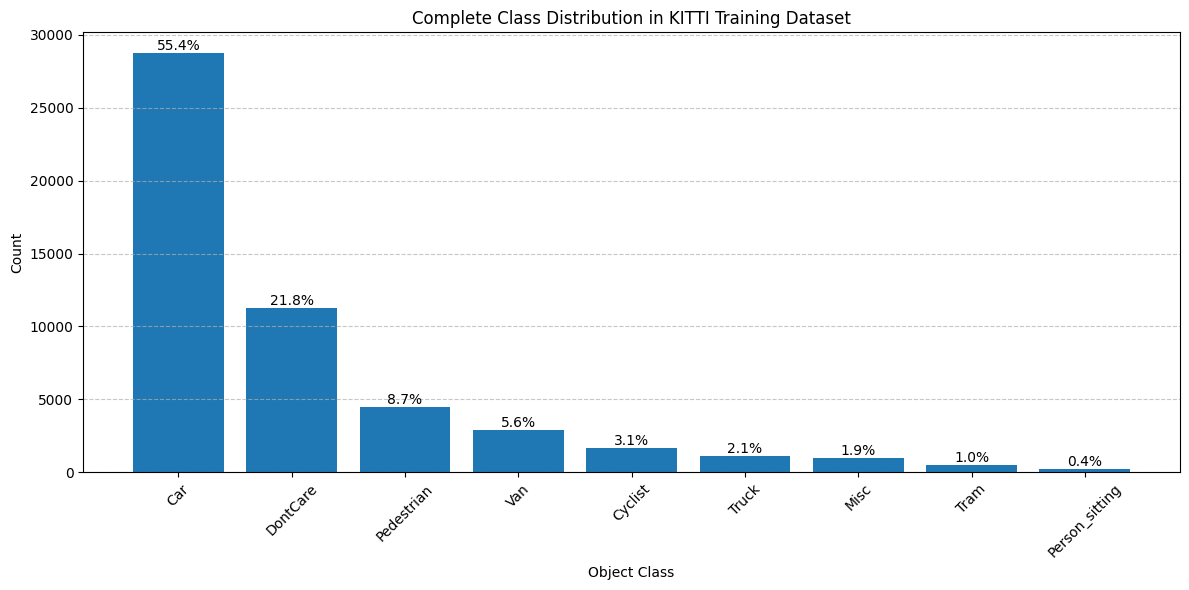


Class Imbalance Analysis:
Most common class: Car with 28742 instances
Least common class: Person_sitting with 222 instances
Imbalance ratio: 129.47:1

Number of distinct object classes: 9

Recommendations based on class distribution:
- Consider class weighting in loss function due to high imbalance
- Data augmentation for minority classes may be beneficial
- Consider focal loss to address class imbalance
- Pay special attention to dominant classes: Car, DontCare
- Consider if rare classes can be merged or require special handling: Tram, Person_sitting


In [ ]:
# Analyze the complete dataset for class distribution
complete_class_counts = Counter()

print("Analyzing complete KITTI training dataset for class distribution...")
start_time = time.time()

# Process all training images
for i in range(len(kitti_train)):
    if i % 500 == 0:
        print(f"Processing image {i}/{len(kitti_train)}...")

    _, targets = kitti_train[i]

    for target in targets:
        if 'type' in target:
            complete_class_counts[target['type']] += 1

# Calculate time taken
elapsed_time = time.time() - start_time
print(f"\nAnalysis completed in {elapsed_time:.2f} seconds")

# Display complete class distribution
total_objects = sum(complete_class_counts.values())
print(f"\nTotal objects: {total_objects}")
print("\nComplete class distribution:")
for cls, count in complete_class_counts.most_common():
    percentage = (count / total_objects) * 100
    print(f"{cls}: {count} instances ({percentage:.2f}%)")

# Plot complete class distribution
plt.figure(figsize=(12, 6))
classes = [cls for cls, _ in complete_class_counts.most_common()]
counts = [count for _, count in complete_class_counts.most_common()]
percentages = [(count / total_objects) * 100 for count in counts]

# Create the bar chart
bars = plt.bar(classes, counts)
plt.title('Complete Class Distribution in KITTI Training Dataset')
plt.xlabel('Object Class')
plt.ylabel('Count')
plt.xticks(rotation=45)

# Add percentage labels on top of bars
for bar, percentage in zip(bars, percentages):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
            f'{percentage:.1f}%',
            ha='center', va='bottom', rotation=0)

plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Generate additional insights
print("\nClass Imbalance Analysis:")
most_common_class = complete_class_counts.most_common(1)[0]
least_common_class = complete_class_counts.most_common()[-1]
imbalance_ratio = most_common_class[1] / least_common_class[1]

print(f"Most common class: {most_common_class[0]} with {most_common_class[1]} instances")
print(f"Least common class: {least_common_class[0]} with {least_common_class[1]} instances")
print(f"Imbalance ratio: {imbalance_ratio:.2f}:1")

# Calculate diversity metrics
class_count = len(complete_class_counts)
print(f"\nNumber of distinct object classes: {class_count}")

- Strong imbalance with `Cars` dominating at 55.42% of all objects
- `DontCare` regions account for 21.78%, which is significant and should be properly handled
- Minor classes like `Person_sitting` (0.43%) and `Tram` (0.99%) have very few examples
- The 129:1 imbalance ratio between most common and least common classes will require special handling

### 2. Bounding Box Size Distribution


Analyzing bounding box sizes...
Processing image 0/7481 for bbox analysis...
Processing image 1000/7481 for bbox analysis...
Processing image 2000/7481 for bbox analysis...
Processing image 3000/7481 for bbox analysis...
Processing image 4000/7481 for bbox analysis...
Processing image 5000/7481 for bbox analysis...
Processing image 6000/7481 for bbox analysis...
Processing image 7000/7481 for bbox analysis...
Bounding box analysis completed in 2364.36 seconds


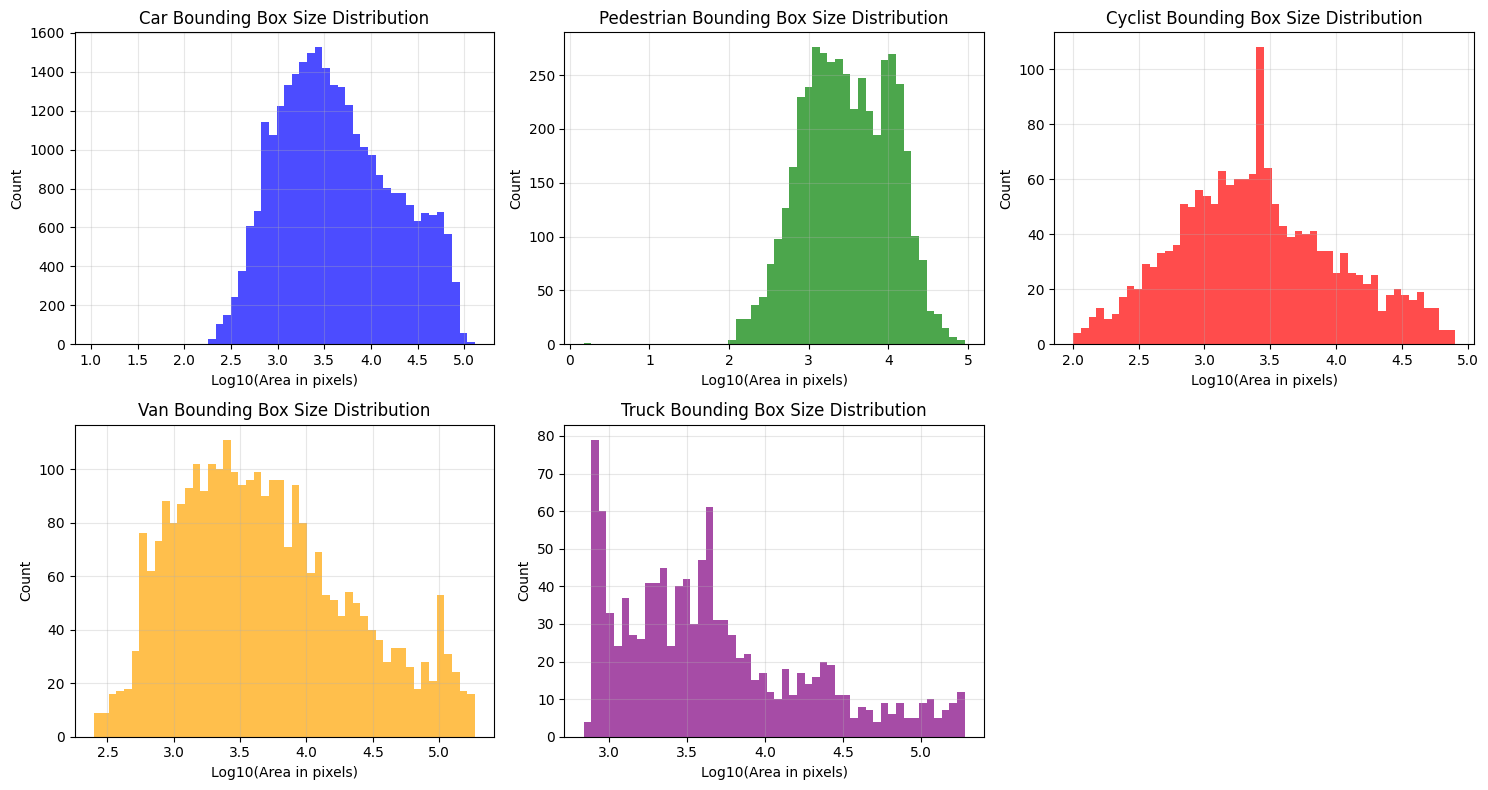

In [ ]:
# This will help understand if we need special handling for small objects
print("\nAnalyzing bounding box sizes...")
start_time = time.time()

bbox_sizes = defaultdict(list)
bbox_aspect_ratios = defaultdict(list)

# Process all training images to collect bounding box information
for i in range(len(kitti_train)):
    if i % 1000 == 0:
        print(f"Processing image {i}/{len(kitti_train)} for bbox analysis...")

    _, targets = kitti_train[i]

    for target in targets:
        if 'type' in target and 'bbox' in target:
            obj_class = target['type']

            # Extract bbox coordinates (assuming format: [x1, y1, x2, y2])
            if len(target['bbox']) == 4:
                x1, y1, x2, y2 = target['bbox']
                width = x2 - x1
                height = y2 - y1
                area = width * height
                aspect_ratio = width / height if height > 0 else 0

                bbox_sizes[obj_class].append(area)
                bbox_aspect_ratios[obj_class].append(aspect_ratio)

elapsed_time = time.time() - start_time
print(f"Bounding box analysis completed in {elapsed_time:.2f} seconds")

# Plot bounding box size distributions for major classes
plt.figure(figsize=(15, 8))
major_classes = ['Car', 'Pedestrian', 'Cyclist', 'Van', 'Truck']
colors = ['blue', 'green', 'red', 'orange', 'purple']

for i, cls in enumerate(major_classes):
    if cls in bbox_sizes and len(bbox_sizes[cls]) > 0:
        areas = bbox_sizes[cls]
        # Use log scale for better visualization
        log_areas = np.log10([a for a in areas if a > 0])

        plt.subplot(2, 3, i+1)
        plt.hist(log_areas, bins=50, alpha=0.7, color=colors[i])
        plt.title(f'{cls} Bounding Box Size Distribution')
        plt.xlabel('Log10(Area in pixels)')
        plt.ylabel('Count')
        plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

- Cars have a log-normal distribution peaking around 10^3.5 pixels in area
- Pedestrians are generally smaller, centered around 10^3.0 pixels
- Cyclists show an interesting spike around 10^3.1 pixels
- Trucks have a multimodal distribution with many very large instances
- Van sizes tend to be larger than cars on average

### 3. Number of Objects per Image


Analyzing objects per image distribution...
Processing image 0/7481 for objects/image analysis...
Processing image 1000/7481 for objects/image analysis...
Processing image 2000/7481 for objects/image analysis...
Processing image 3000/7481 for objects/image analysis...
Processing image 4000/7481 for objects/image analysis...
Processing image 5000/7481 for objects/image analysis...
Processing image 6000/7481 for objects/image analysis...
Processing image 7000/7481 for objects/image analysis...


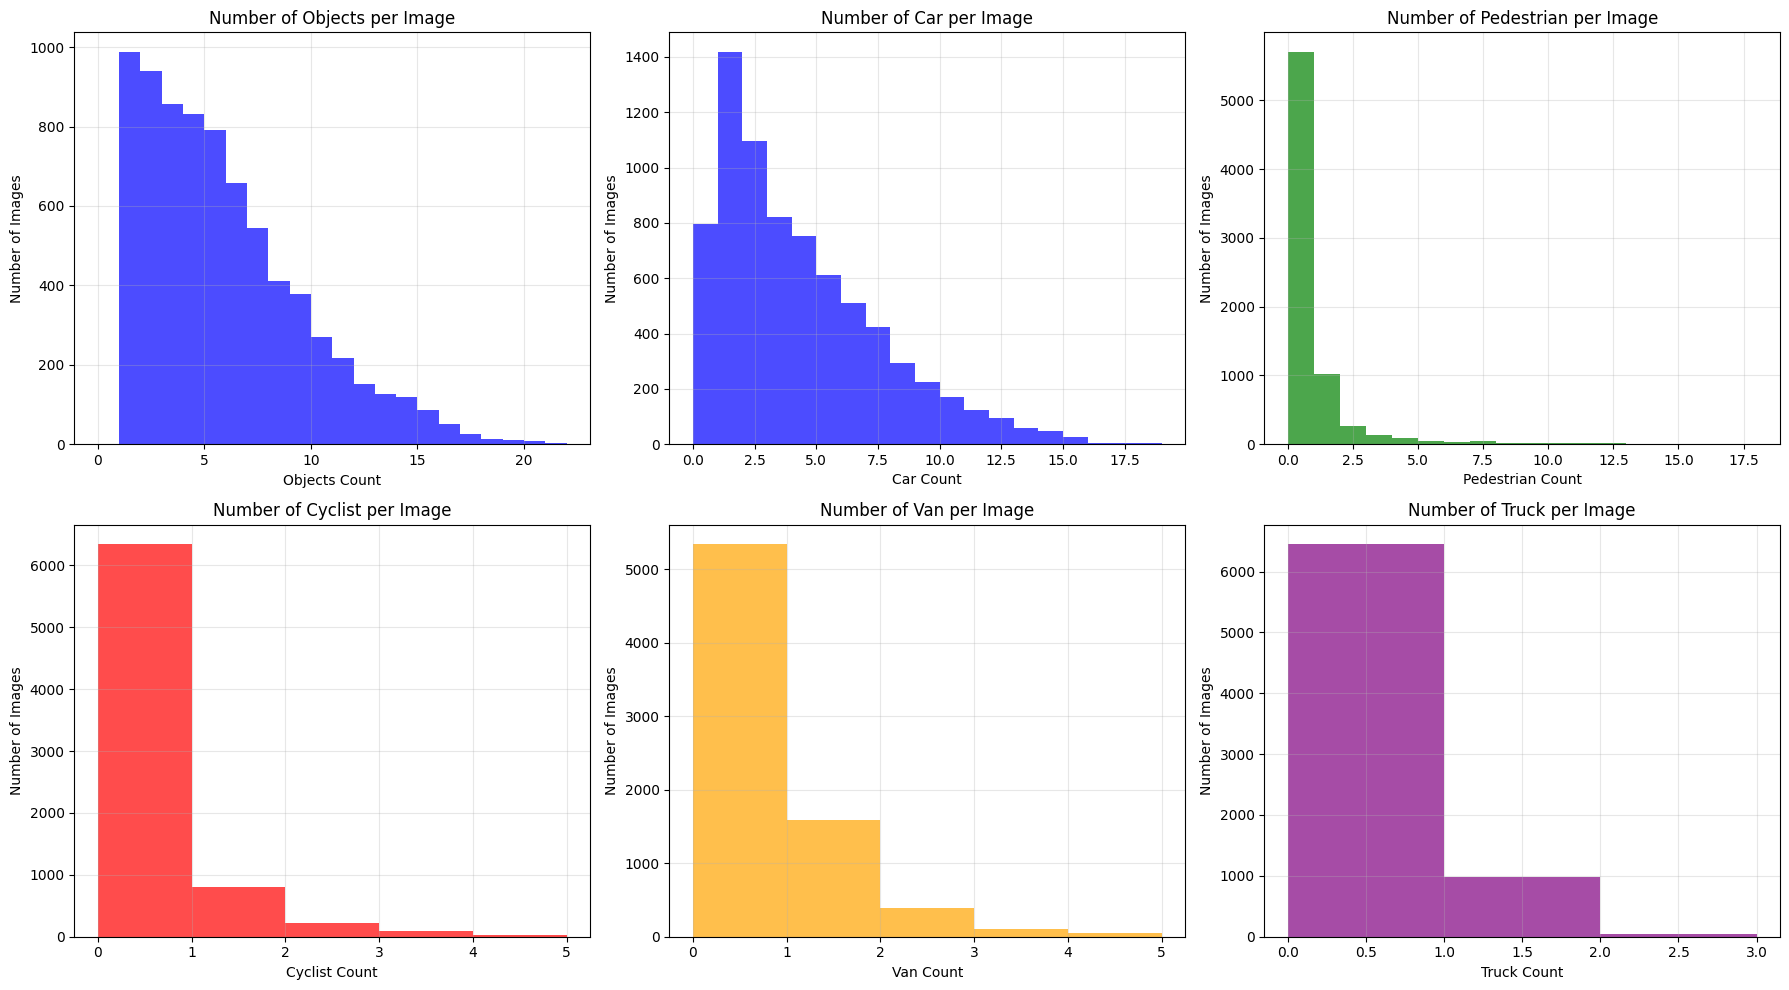

In [ ]:
print("\nAnalyzing objects per image distribution...")
objects_per_image = []
class_objects_per_image = defaultdict(list)

# Process all training images
for i in range(len(kitti_train)):
    if i % 1000 == 0:
        print(f"Processing image {i}/{len(kitti_train)} for objects/image analysis...")

    _, targets = kitti_train[i]

    # Count total objects per image
    total_objects = len([t for t in targets if 'type' in t and t['type'] != 'DontCare'])
    objects_per_image.append(total_objects)

    # Count objects per class per image
    class_counts = Counter([t['type'] for t in targets if 'type' in t])
    for cls in major_classes:
        class_objects_per_image[cls].append(class_counts.get(cls, 0))

# Plot objects per image distribution
plt.figure(figsize=(18, 10))

# Overall objects per image
plt.subplot(2, 3, 1)
plt.hist(objects_per_image, bins=range(0, max(objects_per_image) + 1), alpha=0.7, color='blue')
plt.title('Number of Objects per Image')
plt.xlabel('Objects Count')
plt.ylabel('Number of Images')
plt.grid(alpha=0.3)

# Objects per image by class
for i, cls in enumerate(major_classes):
    plt.subplot(2, 3, i+2)
    plt.hist(class_objects_per_image[cls], bins=range(0, max(class_objects_per_image[cls]) + 1),
             alpha=0.7, color=colors[i])
    plt.title(f'Number of {cls} per Image')
    plt.xlabel(f'{cls} Count')
    plt.ylabel('Number of Images')
    plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

- Most images contain 1-5 objects, with frequency decreasing as object count increases
- Cars appear most frequently, with many images containing multiple cars
- Pedestrians, cyclists, trucks, and vans are much more sparsely distributed across images
- Very few images have more than 2 cyclists, vans, or trucks

### 4. Object Orientation Analysis for Car and Pedestrian


Analyzing object orientations...
Processing image 0/7481 for orientation analysis...
Processing image 1000/7481 for orientation analysis...
Processing image 2000/7481 for orientation analysis...
Processing image 3000/7481 for orientation analysis...
Processing image 4000/7481 for orientation analysis...
Processing image 5000/7481 for orientation analysis...
Processing image 6000/7481 for orientation analysis...
Processing image 7000/7481 for orientation analysis...


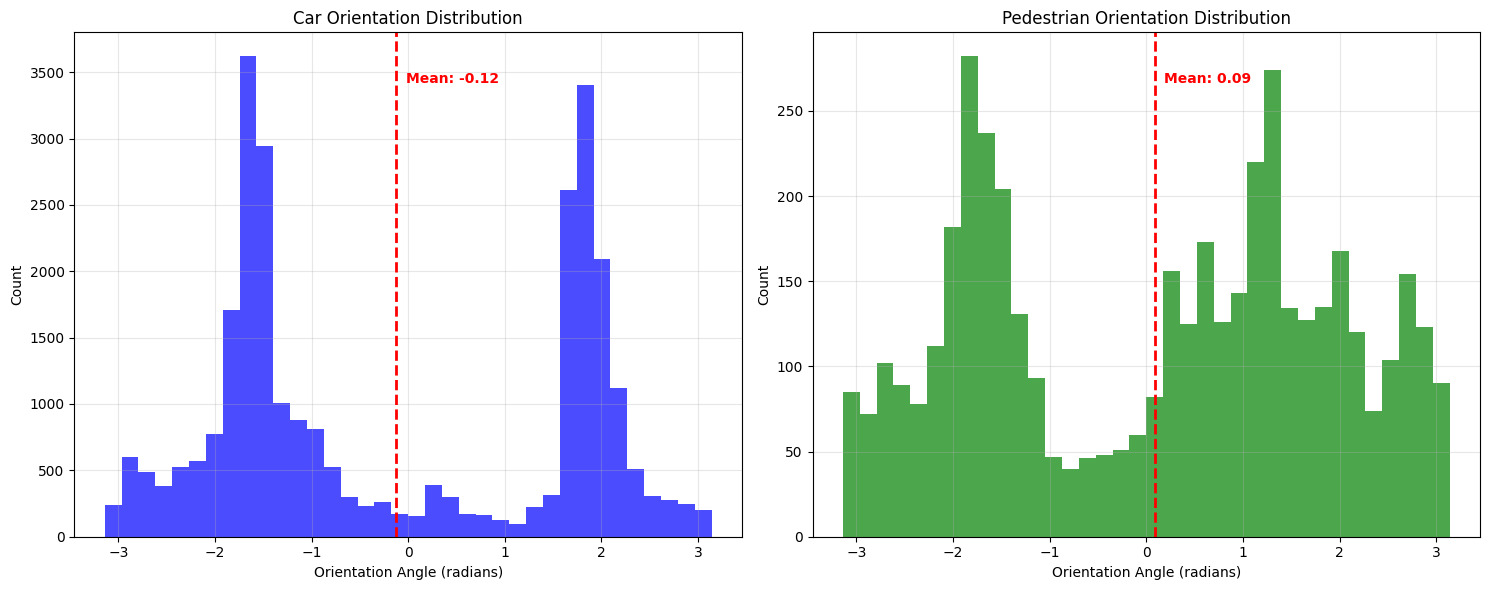

In [ ]:
print("\nAnalyzing object orientations...")
orientations = defaultdict(list)

# Process all training images to collect orientation information
for i in range(len(kitti_train)):
    if i % 1000 == 0:
        print(f"Processing image {i}/{len(kitti_train)} for orientation analysis...")

    _, targets = kitti_train[i]

    for target in targets:
        if 'type' in target and 'alpha' in target:
            obj_class = target['type']
            # Alpha is the observation angle of the object
            orientation = target['alpha']
            orientations[obj_class].append(orientation)

# Plot orientation histograms for Car and Pedestrian
plt.figure(figsize=(15, 6))

for i, cls in enumerate(['Car', 'Pedestrian']):
    if cls in orientations and len(orientations[cls]) > 0:
        plt.subplot(1, 2, i+1)
        plt.hist(orientations[cls], bins=36, alpha=0.7, color=colors[i])
        plt.title(f'{cls} Orientation Distribution')
        plt.xlabel('Orientation Angle (radians)')
        plt.ylabel('Count')
        plt.grid(alpha=0.3)

        # Add some statistics
        mean_orientation = np.mean(orientations[cls])
        plt.axvline(mean_orientation, color='red', linestyle='dashed', linewidth=2)
        plt.text(mean_orientation + 0.1, plt.ylim()[1]*0.9, f'Mean: {mean_orientation:.2f}',
                 color='red', fontweight='bold')

plt.tight_layout()
plt.show()

- Cars show strong bimodal orientation, with peaks around -1.5 and +2.0 radians. This likely corresponds to cars moving in opposite directions on roads
- Pedestrians have a more uniform distribution across all orientations, but with notable peaks around -2.0 and +1.0 radians

### 5. Occlusion and Truncation Analysis


Analyzing occlusion and truncation levels...
Processing image 0/7481 for occlusion/truncation analysis...
Processing image 1000/7481 for occlusion/truncation analysis...
Processing image 2000/7481 for occlusion/truncation analysis...
Processing image 3000/7481 for occlusion/truncation analysis...
Processing image 4000/7481 for occlusion/truncation analysis...
Processing image 5000/7481 for occlusion/truncation analysis...
Processing image 6000/7481 for occlusion/truncation analysis...
Processing image 7000/7481 for occlusion/truncation analysis...


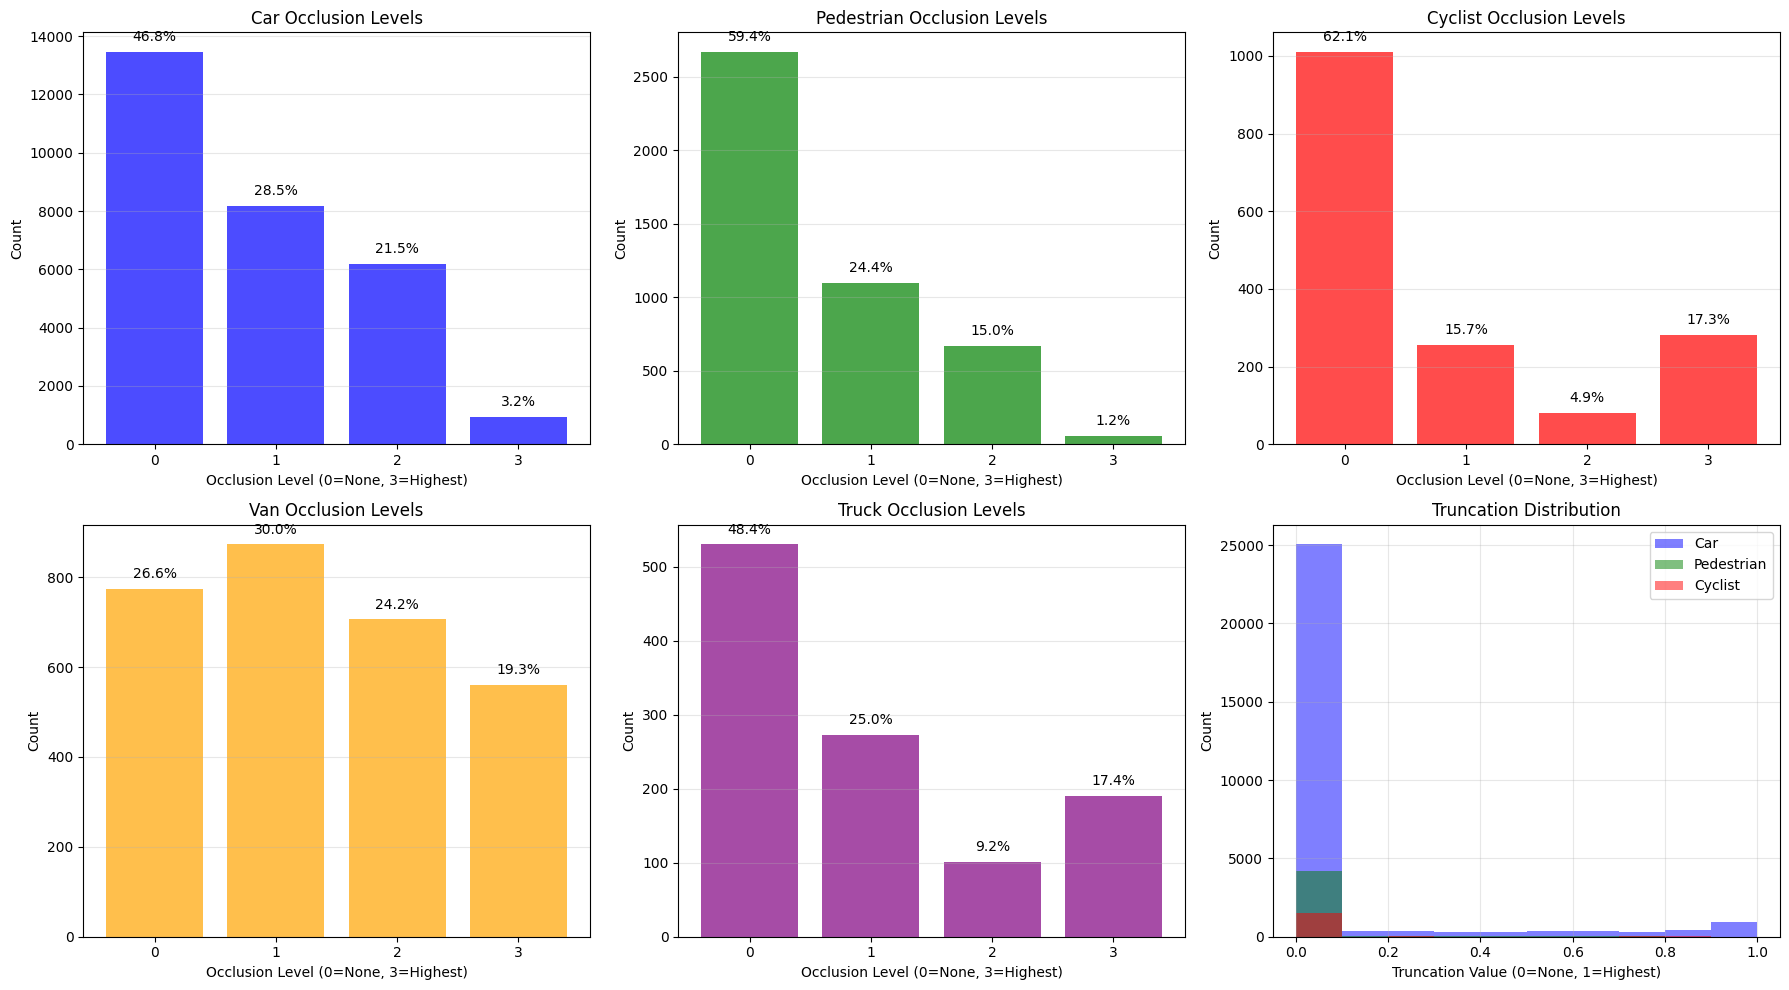

In [ ]:
print("\nAnalyzing occlusion and truncation levels...")
occlusion_counts = defaultdict(Counter)
truncation_values = defaultdict(list)

# Process all training images to collect occlusion and truncation information
for i in range(len(kitti_train)):
    if i % 1000 == 0:
        print(f"Processing image {i}/{len(kitti_train)} for occlusion/truncation analysis...")

    _, targets = kitti_train[i]

    for target in targets:
        if 'type' in target:
            obj_class = target['type']

            # Collect occlusion information (typically 0, 1, 2, 3 for different levels)
            if 'occluded' in target:
                occlusion_counts[obj_class][target['occluded']] += 1

            # Collect truncation information (typically a float from 0 to 1)
            if 'truncated' in target:
                truncation_values[obj_class].append(target['truncated'])

# Plot occlusion levels for major classes
plt.figure(figsize=(18, 10))

for i, cls in enumerate(major_classes):
    if cls in occlusion_counts:
        plt.subplot(2, 3, i+1)
        occ_levels = list(range(4))  # Occlusion levels are typically 0, 1, 2, 3
        counts = [occlusion_counts[cls][level] for level in occ_levels]

        plt.bar(occ_levels, counts, alpha=0.7, color=colors[i])
        plt.title(f'{cls} Occlusion Levels')
        plt.xlabel('Occlusion Level (0=None, 3=Highest)')
        plt.ylabel('Count')
        plt.xticks(occ_levels)
        plt.grid(axis='y', alpha=0.3)

        # Add percentage labels
        total = sum(counts)
        for j, count in enumerate(counts):
            if total > 0:
                percentage = (count / total) * 100
                plt.text(j, count + (max(counts) * 0.02), f'{percentage:.1f}%',
                         ha='center', va='bottom')

# Plot truncation distributions
plt.subplot(2, 3, 6)
for i, cls in enumerate(major_classes[:3]):  # Just show top 3 classes for clarity
    if cls in truncation_values and len(truncation_values[cls]) > 0:
        plt.hist(truncation_values[cls], bins=10, alpha=0.5, color=colors[i], label=cls)

plt.title('Truncation Distribution')
plt.xlabel('Truncation Value (0=None, 1=Highest)')
plt.ylabel('Count')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

- Most objects have no occlusion (level 0), but significant numbers are partially occluded
- Cars: 53.2% have some level of occlusion, particularly challenging for detection
- Vans: 73.4% have occlusion, the highest among all classes
- Cyclists show high levels of level 3 (highest) occlusion at 17.3%

- Truncation is generally low across all classes, with cars having some high truncation cases

### Key Insights

- We need to use focal loss to address the 129:1 imbalance ratio
- We can consider oversampling minority classes or applying class weights
- We need to augment the rare classes (Person_sitting, Tram)
- We might want to consider rotational augmentation for car detection given the bimodal orientation
- The high occlusion rates for vans (73.4%) and cars (53.2%) suggest we may need occlusion-robust techniques
- We should evaluate performance separately on occluded vs. non-occluded objects